# Classifier Training
Single-label + Pseudo-single-label + Pseudo-multi-label.

In [1]:
! rsync -a /kaggle/input/mmdetection-v280/mmdetection /
! pip install /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
! pip install /kaggle/input/hpapytorchzoo/pytorch_zoo-master/
! pip install /kaggle/input/hpacellsegmentation/HPA-Cell-Segmentation/
! pip install /kaggle/input/iterative-stratification/iterative-stratification-master/

! cp -r /kaggle/input/kgl-humanprotein-data/kgl_humanprotein_data /
! cp -r /kaggle/input/humanpro/kgl_humanprotein /

import sys
sys.path.append('/kgl_humanprotein/')

Processing /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl size=272905 sha256=c303dde7e30ce05f95485940741c8fb9deb905e8d691505b4d9bdfc58d6f21a1
  Stored in directory: /root/.cache/pip/wheels/80/e0/da/3288fdf3965b5c9090f368462db9d28be2c82013f51821090a
Successfully built mmpycocotools
Processing /kaggle/input/hpapytorchzoo/pytorch_zoo-master
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=a35382b5c395ba5e89284a958995677e1ee24134cff8ccf9a32b4e500dad1076
  Stored in directory: /root/.cache/pip/wheels/7f/18/21/aff5a8914e22461b2b025a9629c2b70464c36183caaf12bc09
Successfully built pytorch-zoo
Processing /kaggle/input/hpacellsegmentation/HPA-Cell-Segmentation
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.whl size=14815 sha256=7923e7c782d4c6a3a7abaf9c3c6942796dc84e1a8e6484dafca12e37262d1201
  Stored in di

In [2]:
import os
import time
from pathlib import Path
import shutil
import zipfile
import functools
import multiprocessing
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import KFold,StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
from torch.backends import cudnn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import DataParallel
import matplotlib.pyplot as plt
from tqdm import tqdm

from kgl_humanprotein.utils.common_util import *
from kgl_humanprotein.config.config import *
from kgl_humanprotein.data_process import *
from kgl_humanprotein.datasets.tool import image_to_tensor
from kgl_humanprotein.networks.imageclsnet import init_network
from kgl_humanprotein.layers.loss import *
from kgl_humanprotein.layers.scheduler import *
from kgl_humanprotein.utils.augment_util import train_multi_augment2
from kgl_humanprotein.utils.log_util import Logger
from kgl_humanprotein.run.train import *

run on e4c7f5537543


In [3]:
%cd /kaggle

/kaggle


In [4]:
dir_data = Path('/kaggle/input')
dir_mdata = Path('/kaggle/mdata')

# Data

In [5]:
def load_subset5_raw():
    pth = Path('/kaggle/input/humanpro-train-cells-subset5/humanpro_train_cells_subset5/train/train.feather')
    df = pd.read_feather(pth)
    df['subset'] = 5
    return df

def load_subsets_raw():
    df_0to4 = pd.read_feather('/kaggle/input/humanpro-raw-meta-channel-max/train.feather')    
    df_5 = load_subset5_raw()
    df = pd.concat([df_0to4, df_5], axis=0, ignore_index=True)
    return df

def load_pseudo_raw():
    return pd.read_feather('/kaggle/input/humanpro-data-multilabel-cells-meta/train.feather')    

def seperate_single_multi_labels(df):
    is_singlelabel = df.Target.apply(lambda o: len(o.split('|')) == 1)
    return df[is_singlelabel], df[~is_singlelabel]

def replace_multi_with_pseudo(df_orig_multi, df_pseudo):
    df = pd.merge(df_orig_multi, df_pseudo[['Id', 'Target']], left_on='Id', right_on='Id', how='inner')
    df.rename({'Target_x':'original_target', 'Target_y':'Target'}, axis=1, inplace=True)
    return df

In [6]:
%%time

df_orig = load_subsets_raw()
df_orig_sgl, df_orig_mul = seperate_single_multi_labels(df_orig)

df_pseudo = load_pseudo_raw()
df_pseudo = replace_multi_with_pseudo(df_orig_mul, df_pseudo)

df_cells = pd.concat([df_orig_sgl, df_pseudo], axis=0, ignore_index=True)
df_cells = df_cells[df_cells.Target != ''].reset_index(drop=True)

df_orig.shape, df_orig_sgl.shape, df_orig_mul.shape, df_pseudo.shape, df_cells.shape

CPU times: user 3.43 s, sys: 1.54 s, total: 4.97 s
Wall time: 10.4 s


((529104, 9), (287504, 9), (241600, 9), (241600, 10), (441403, 10))

In [7]:
del df_orig, df_orig_sgl, df_orig_mul, df_pseudo

In [8]:
dir_mdata_raw = dir_mdata/'raw'
dir_mdata_raw.mkdir(exist_ok=True, parents=True)

df_cells.to_feather(dir_mdata_raw/'train.feather')

## Data preview

In [9]:
nsample = 10
df = df_cells.sample(nsample).reset_index(drop=True)

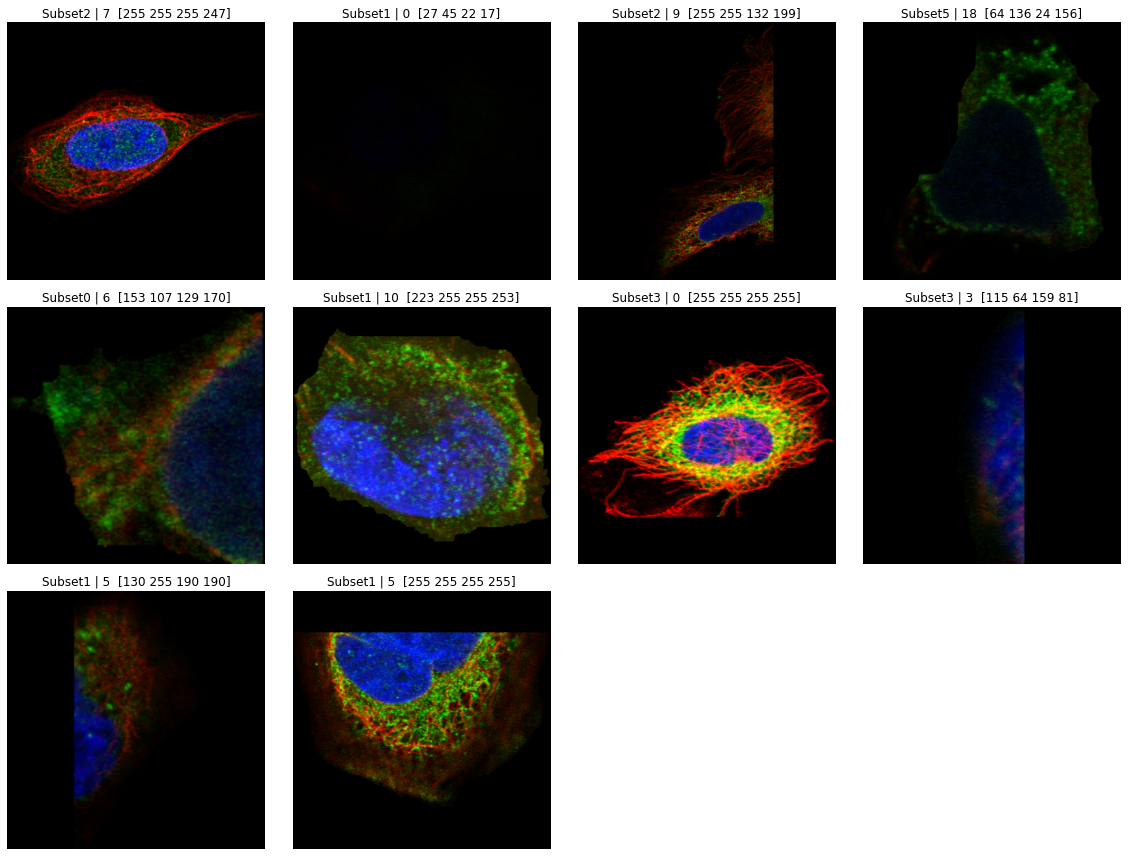

In [10]:
ncols = 4

nrows = (nsample - 1) // ncols + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axs = axs.flatten()
for ax in axs:
    ax.axis('off')
for ax, (_, r) in zip(axs, df.iterrows()):
    dir_img = (dir_data
               /f'humanpro-train-cells-subset{r.subset}'
               /f'humanpro_train_cells_subset{r.subset}'/'train'/'images_384')
    img = load_RGBY_image(dir_img, r.Id)
    ax.imshow(img[...,[0,3,2]])
    ax.set_title(f"Subset{r.subset} | {r.Target}  {r[['max_red', 'max_green', 'max_blue', 'max_yellow']].values}")
    
plt.tight_layout()

In [11]:
del df

## Filter samples

In [12]:
df_cells = pd.read_feather(dir_mdata/'raw'/'train.feather')

In [13]:
def cap_number_per_label(df_cells, cap=10_000, idx_start=0):
    '''
    Limit number of samples per label
    '''
    df_cells_cap = pd.DataFrame()
    for label in df_cells.Target.unique():
        df = df_cells[df_cells.Target==label]
        if len(df) > cap:
            df = df.iloc[idx_start:idx_start + cap]
        df_cells_cap = df_cells_cap.append(df, ignore_index=True)
    return df_cells_cap

In [14]:
df_cells = cap_number_per_label(df_cells, cap=10_000, idx_start=0) 

In [15]:
df_cells.to_feather(dir_mdata_raw/'train.feather')

## One-hot encode labels

In [16]:
%%time
generate_meta(dir_mdata, 'train.feather')

CPU times: user 45.9 s, sys: 873 ms, total: 46.8 s
Wall time: 46.6 s


## Split generation

In [17]:
%%time
train_meta = pd.read_feather(dir_mdata/'meta'/'train_meta.feather')
create_random_split(dir_mdata, train_meta, n_splits=5, alias='random')
del train_meta

Nucleoplasm 11923 2980
Nuclear membrane 8720 2180
Nucleoli 9069 2267
Nucleoli fibrillar center 8214 2053
Nuclear speckles 8377 2095
Nuclear bodies 9091 2272
Endoplasmic reticulum 8232 2058
Golgi apparatus 8714 2179
Intermediate filaments 8214 2053
Actin filaments 7955 1989
Microtubules 8234 2059
Mitotic spindle 138 34
Centrosome 8459 2115
Plasma membrane 9771 2443
Mitochondria 8513 2128
Aggresome 2698 675
Cytosol 10083 2520
Vesicles and punctate cytosolic patterns 5301 1325
Negative 8000 2000
create split file: /kaggle/mdata/split/random_folds5/random_train_cv0.feather, shape: (142550, 30)
create split file: /kaggle/mdata/split/random_folds5/random_valid_cv0.feather, shape: (35673, 30)
create split file: /kaggle/mdata/split/random_folds5/random_train_cv1.feather, shape: (142539, 30)
create split file: /kaggle/mdata/split/random_folds5/random_valid_cv1.feather, shape: (35684, 30)
create split file: /kaggle/mdata/split/random_folds5/random_train_cv2.feather, shape: (142589, 30)
create sp

## Training

In [18]:
from kgl_humanprotein.datasets.protein_dataset import ProteinDataset
from torch.utils.data.sampler import WeightedRandomSampler

def main_training(dir_data, dir_mdata, dir_results, out_dir, gpu_id='0', 
                  arch='class_densenet121_dropout', pretrained=None, model_multicell=None, 
                  num_classes=19, in_channels=4, loss='FocalSymmetricLovaszHardLogLoss',
                  scheduler='Adam45', epochs=55, img_size=768, crop_size=512, batch_size=32, 
                  workers=3, pin_memory=True, split_name='random_ext_folds5', fold=0, 
                  clipnorm=1, resume=None):
    '''
    PyTorch Protein Classification.  Main training function.
    
    Args:
        dir_data (str, Path): Directory where training subsets are.
        dir_mdata (str, Path): Directory where training meta data is.
        dir_results (std, Path): Directory to save training results.
        out_dir (str): 
            Name/label for this training run.  Will be used to create
            directory under `dir_results`.
        gpu_id (str): GPU id used for training. Default: '0'
        arch (str): Model architecture.  
            Default: ``'class_densenet121_dropout'``
        pretrained (Path, str): Path to a pretrained model.  These are
            the parameters just before training starts.
        model_multicell (Path, str): Path to multi-cell model 
            to start training from. Default: None
        num_classes (int): Number of classes. Default: 19 
        in_channels (int): In channels. Default: 4
        loss (str, optional): Loss function. 
            One of ``'FocalSymmetricLovaszHardLogLoss'``. 
            Default: ``'FocalSymmetricLovaszHardLogLoss'``
        scheduler (str): Scheduler name. Default: ``'Adam45'``
        epochs (int): Number of total epochs to run. Default: 55
        img_size (int): Image size.  Default: 768
        crop_size (int): Crop size.  Default: 512
        batch_size (int): Train mini-batch size. Default: 32
        workers (int): Number of data loading workers. Default: 3
        pin_memory (bool): DataLoader's ``pin_memory`` argument.
        split_name (str, optional): Split name.  
            One of: ``'random_ext_folds5'``, 
            or ``'random_ext_noleak_clean_folds5'``. 
            Default: ``'random_ext_folds5'``
        fold (int): Index of fold. Default: 0
        clipnorm (int): Clip grad norm'. Default: 1
        resume (str): Name of the latest checkpoint. Default: None
    '''
    log_out_dir = opj(dir_results, 'logs', out_dir, 'fold%d' % fold)
    if not ope(log_out_dir):
        os.makedirs(log_out_dir)
    log = Logger()
    log.open(opj(log_out_dir, 'log.train.txt'), mode='a')

    model_out_dir = opj(dir_results, 'models', out_dir, 'fold%d' % fold)
    log.write(">> Creating directory if it does not exist:\n>> '{}'\n".format(model_out_dir))
    if not ope(model_out_dir):
        os.makedirs(model_out_dir)

    # set cuda visible device
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id
    cudnn.benchmark = True

    # set random seeds
    torch.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    np.random.seed(0)

    model_params = {}
    model_params['architecture'] = arch
    model_params['num_classes'] = num_classes
    model_params['in_channels'] = in_channels
    model = init_network(model_params, model_multicell=model_multicell)
    
    if pretrained:
        print(f'Loading pretrained model {pretrained}')
        checkpoint = torch.load(pretrained)
        model.load_state_dict(checkpoint['state_dict'])
    
    # move network to gpu
    model = DataParallel(model)
    model.to(DEVICE)

    # define loss function (criterion)
    try:
        criterion = eval(loss)().to(DEVICE)
    except:
        raise(RuntimeError("Loss {} not available!".format(loss)))

    start_epoch = 0
    best_loss = 1e5
    best_epoch = 0
    best_focal = 1e5

    # define scheduler
    try:
        scheduler = eval(scheduler)()
    except:
        raise (RuntimeError("Scheduler {} not available!".format(scheduler)))
    optimizer = scheduler.schedule(model, start_epoch, epochs)[0]

    # optionally resume from a checkpoint
    if resume:
        resume = os.path.join(model_out_dir, resume)
        if os.path.isfile(resume):
            # load checkpoint weights and update model and optimizer
            log.write(">> Loading checkpoint:\n>> '{}'\n".format(resume))

            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_epoch = checkpoint['best_epoch']
            best_focal = checkpoint['best_score']
            model.module.load_state_dict(checkpoint['state_dict'])

            optimizer_fpath = resume.replace('.pth', '_optim.pth')
            if ope(optimizer_fpath):
                log.write(">> Loading checkpoint:\n>> '{}'\n".format(optimizer_fpath))
                optimizer.load_state_dict(torch.load(optimizer_fpath)['optimizer'])
            log.write(">>>> loaded checkpoint:\n>>>> '{}' (epoch {})\n".format(resume, checkpoint['epoch']))
        else:
            log.write(">> No checkpoint found at '{}'\n".format(resume))

    # Data loading code
    train_transform = train_multi_augment2
    train_split_file = dir_mdata / 'split'/ split_name / f'random_train_cv{fold}.feather'
    train_dataset = ProteinDataset(
        dir_data,
        train_split_file,
        img_size=img_size,
        is_trainset=True,
        return_label=True,
        in_channels=in_channels,
        transform=train_transform,
        crop_size=crop_size,
        random_crop=True)
    
    label_weights = get_label_weights(train_dataset.split_df)
    weights = torch.from_numpy(train_dataset.split_df['Target']
                               .apply(lambda o: label_weights[o]).values)
    sampler = WeightedRandomSampler(weights, len(weights))
    
    train_loader = DataLoader(
        train_dataset,
        sampler=sampler,
        batch_size=batch_size,
        drop_last=True,
        num_workers=workers,
        pin_memory=pin_memory)
    
    valid_split_file = (dir_mdata/'split'/split_name/
                        f'random_valid_cv{fold}.feather')
    
    valid_dataset = ProteinDataset(
        dir_data,
        valid_split_file,
        img_size=img_size,
        is_trainset=True,
        return_label=True,
        in_channels=in_channels,
        transform=None,
        crop_size=crop_size,
        random_crop=False)
    
    valid_loader = DataLoader(
        valid_dataset,
        sampler=SequentialSampler(valid_dataset),
        batch_size=batch_size,
        drop_last=False,
        num_workers=workers,
        pin_memory=pin_memory)

    focal_loss = FocalLoss().to(DEVICE)
    log.write('** start training here! **\n')
    log.write('\n')
    log.write('epoch    iter      rate     |  train_loss/acc  |    valid_loss/acc/focal/kaggle     |best_epoch/best_focal|  min \n')
    log.write('-----------------------------------------------------------------------------------------------------------------\n')
    start_epoch += 1
    for epoch in range(start_epoch, epochs + 1):
        end = time.time()

        # set manual seeds per epoch
        np.random.seed(epoch)
        torch.manual_seed(epoch)
        torch.cuda.manual_seed_all(epoch)

        # adjust learning rate for each epoch
        lr_list = scheduler.step(model, epoch, epochs)
        lr = lr_list[0]

        # train for one epoch on train set
        iter, train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, clipnorm=clipnorm, lr=lr)

        with torch.no_grad():
            valid_loss, valid_acc, valid_focal_loss, kaggle_score = validate(valid_loader, model, criterion, epoch, focal_loss)

        # remember best loss and save checkpoint
        is_best = valid_focal_loss < best_focal
        best_loss = min(valid_focal_loss, best_loss)
        best_epoch = epoch if is_best else best_epoch
        best_focal = valid_focal_loss if is_best else best_focal

        print('\r', end='', flush=True)
        log.write('%5.1f   %5d    %0.6f   |  %0.4f  %0.4f  |    %0.4f  %6.4f %6.4f %6.4f    |  %6.1f    %6.4f   | %3.1f min \n' % \
                  (epoch, iter + 1, lr, train_loss, train_acc, valid_loss, valid_acc, valid_focal_loss, kaggle_score,
                   best_epoch, best_focal, (time.time() - end) / 60))

        save_model(model, is_best, model_out_dir, optimizer=optimizer, epoch=epoch, best_epoch=best_epoch, best_focal=best_focal)


In [19]:
model_multicell = (
    '../../kgl_humanprotein_data/result/models/'
    'external_crop512_focal_slov_hardlog_class_densenet121_dropout_i768_aug2_5folds/'
    'fold0/final.pth')
pretrained = Path(
    '/kaggle/input/humanpro-classifier-crop/results/models/'
    'external_crop256_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds/'
    'fold0/final.pth')

gpu_id = '0' # '0,1,2,3'
arch = 'class_densenet121_dropout'
num_classes = len(LABEL_NAME_LIST)
scheduler = 'Adam55'
epochs = 12 #55
resume = Path('/kaggle/input/humanpro-classifier-2/results/models/'
              'external_crop256_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds/'
              'fold0/final.pth') 
sz_img = 384
crop_size = 256 #512
batch_size = 76
split_name = 'random_folds5'
fold = 0
workers = 3
pin_memory = True

dir_results = Path('results')
dir_results.mkdir(exist_ok=True, parents=True)

out_dir = Path(f'external_crop{crop_size}_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds')

In [20]:
main_training(dir_data, dir_mdata, dir_results, out_dir, 
              split_name=split_name, fold=fold,
              arch=arch, pretrained=pretrained, model_multicell=model_multicell, scheduler=scheduler,
              epochs=epochs, resume=resume,
              img_size=sz_img, crop_size=crop_size, batch_size=batch_size, 
              gpu_id=gpu_id, workers=workers, pin_memory=pin_memory)

>> Creating directory if it does not exist:
>> 'results/models/external_crop256_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds/fold0'
>> Using pre-trained model.
>> Loading multi-cell model.
Loading pretrained model /kaggle/input/humanpro-classifier-crop/results/models/external_crop256_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds/fold0/final.pth
>> Loading checkpoint:
>> '/kaggle/input/humanpro-classifier-2/results/models/external_crop256_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds/fold0/final.pth'
>> Loading checkpoint:
>> '/kaggle/input/humanpro-classifier-2/results/models/external_crop256_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds/fold0/final_optim.pth'
>>>> loaded checkpoint:
>>>> '/kaggle/input/humanpro-classifier-2/results/models/external_crop256_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds/fold0/final.pth' (epoch 6)
** start training here! **

epoch    iter      rate     |  train_loss/acc  |   

In [21]:
! cp -r results/ /kaggle/working/.